In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from ydata_profiling import ProfileReport
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
print(tf.config.list_physical_devices())
print(tf.__version__)

2024-06-15 18:08:39.530924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 18:08:39.531059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 18:08:39.678129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.15.0


# Data Analysis

In [2]:
df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [3]:
Labels_Profile = ProfileReport(df, progress_bar= False)
Labels_Profile.to_notebook_iframe()

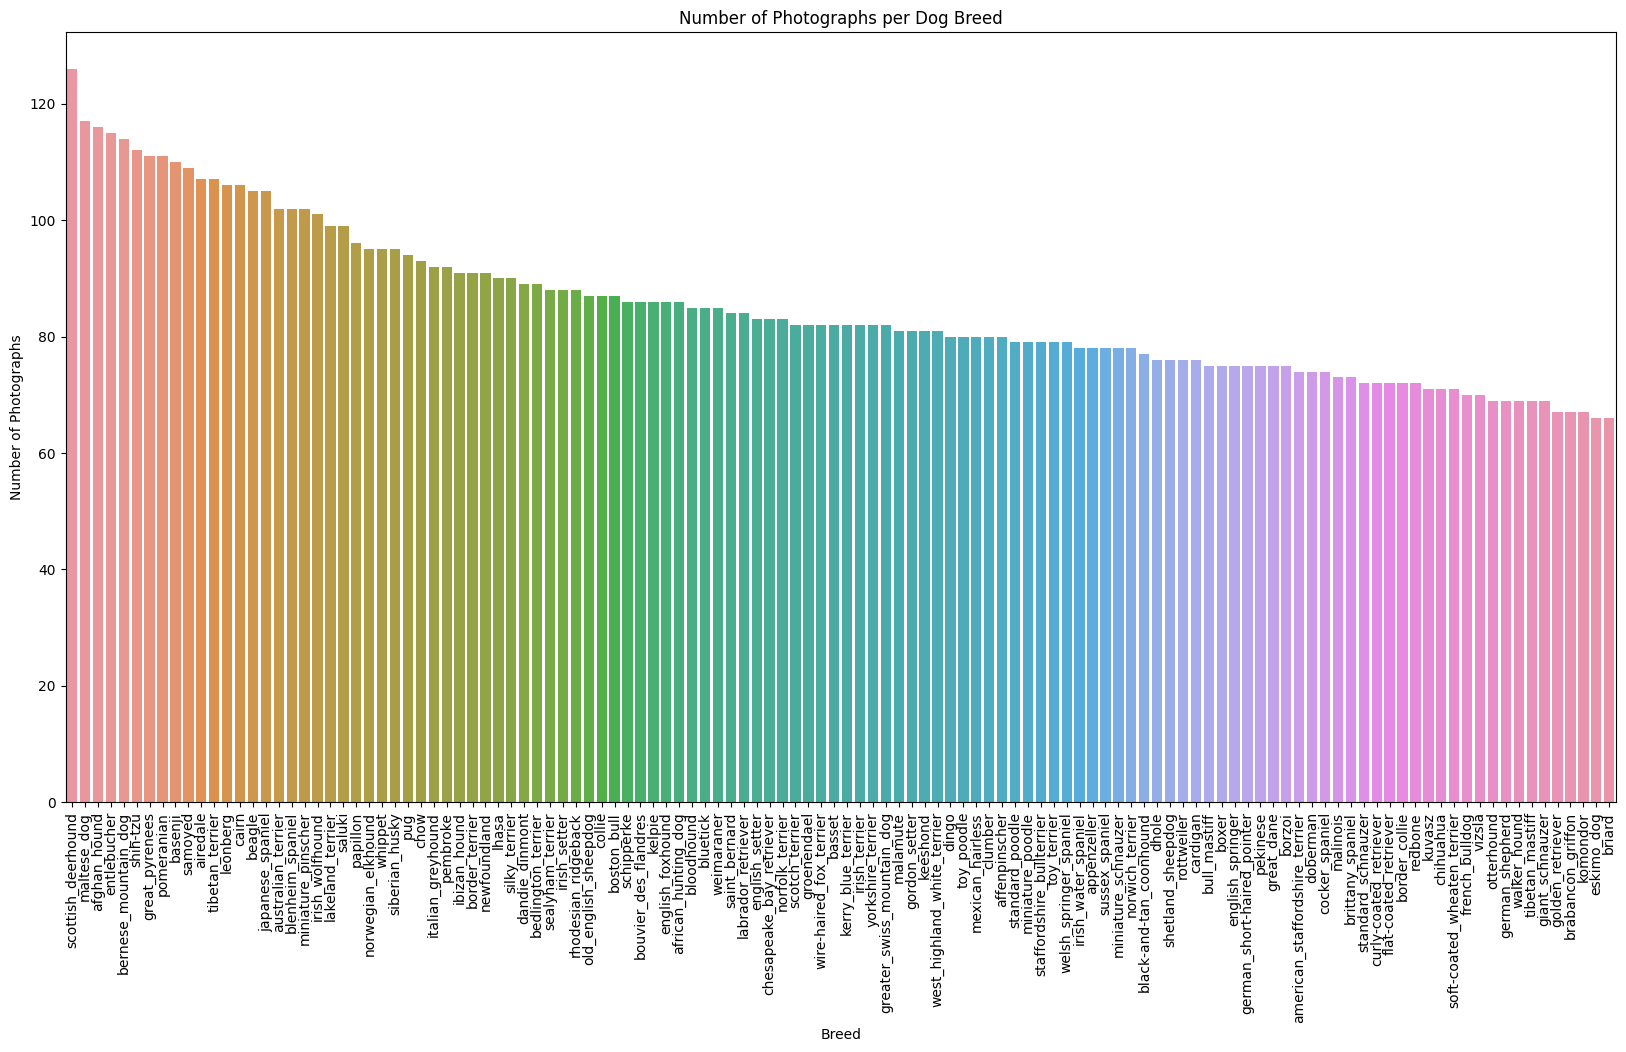

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure inline plotting in Jupyter notebooks
%matplotlib inline

# Load the dataset
df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')

# Count the number of photographs for each breed
breed_counts = df['breed'].value_counts()

# Plot the counts
plt.figure(figsize=(20, 10))
sns.barplot(x=breed_counts.index, y=breed_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Breed')
plt.ylabel('Number of Photographs')
plt.title('Number of Photographs per Dog Breed')
plt.show()

In [5]:
# Count the number of photographs for each breed
breed_counts = df['breed'].value_counts()

# Print the counts
print(breed_counts)

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64


In [6]:
breed_counts = df['breed'].value_counts()
included_breeds = breed_counts[breed_counts > 100].index.tolist()
df = df[df['breed'].isin(included_breeds)].reset_index(drop=True)

In [7]:
df.shape


(2184, 2)

In [8]:
image_dir = '/kaggle/input/dog-breed-identification/train'
test_dir = '/kaggle/input/dog-breed-identification/test'

# Resize Images

In [9]:
def read_and_resize_image_rgb(file_path):
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img_rgb_resized = cv2.resize(img_rgb, (224, 224))
    return img_rgb_resized

In [10]:
resized_images = []
for idx, filename in enumerate(df['id']):
    img_path = os.path.join(image_dir, filename + '.jpg')
    resized_img = read_and_resize_image_rgb(img_path)
    resized_images.append(resized_img)
resized_images_array = np.array(resized_images)

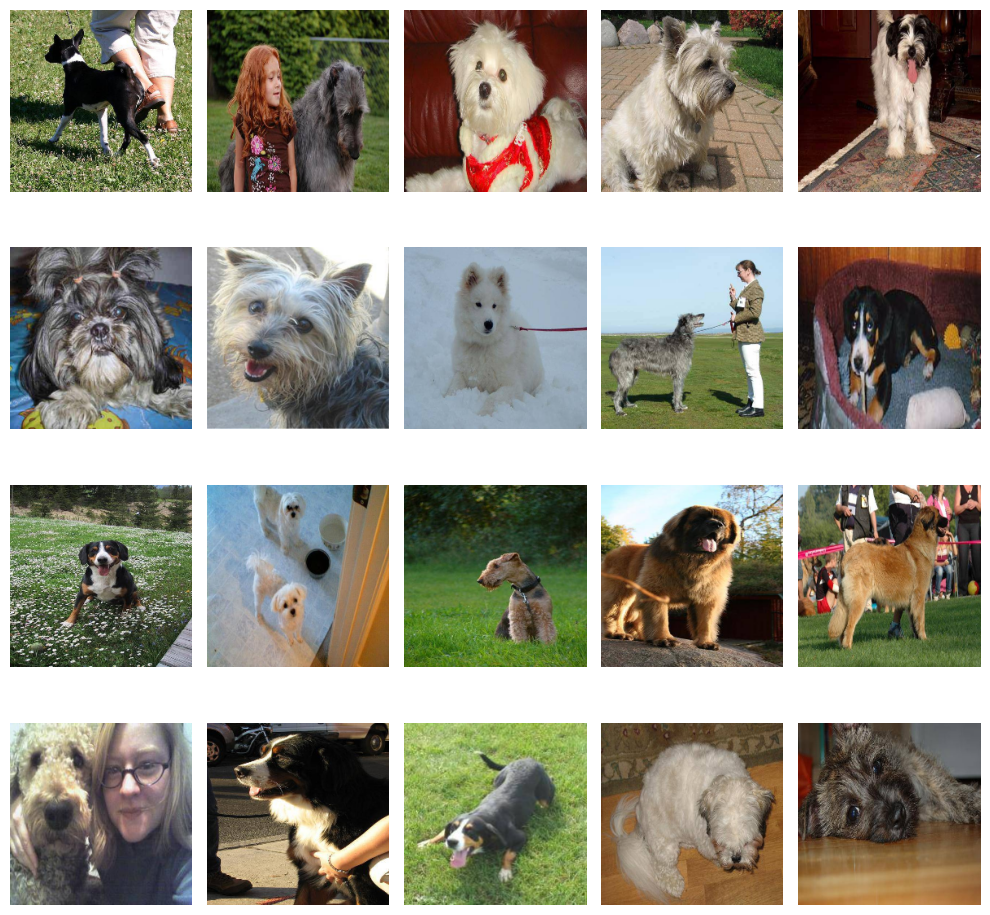

In [11]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(resized_images_array[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
unique_breeds = df['breed'].unique()
print(unique_breeds)

['basenji' 'scottish_deerhound' 'maltese_dog' 'cairn' 'tibetan_terrier'
 'shih-tzu' 'australian_terrier' 'samoyed' 'entlebucher' 'airedale'
 'leonberg' 'bernese_mountain_dog' 'afghan_hound' 'miniature_pinscher'
 'irish_wolfhound' 'great_pyrenees' 'beagle' 'japanese_spaniel'
 'pomeranian' 'blenheim_spaniel']


# **Label Encoding**

In [13]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(df['breed'])
new_labels = to_categorical(label_encoded)

In [14]:
X = resized_images_array
y = new_labels

# **Train Test Split**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1747, 224, 224, 3)
(437, 224, 224, 3)
(1747, 20)
(437, 20)


# **Data Augmentation**

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

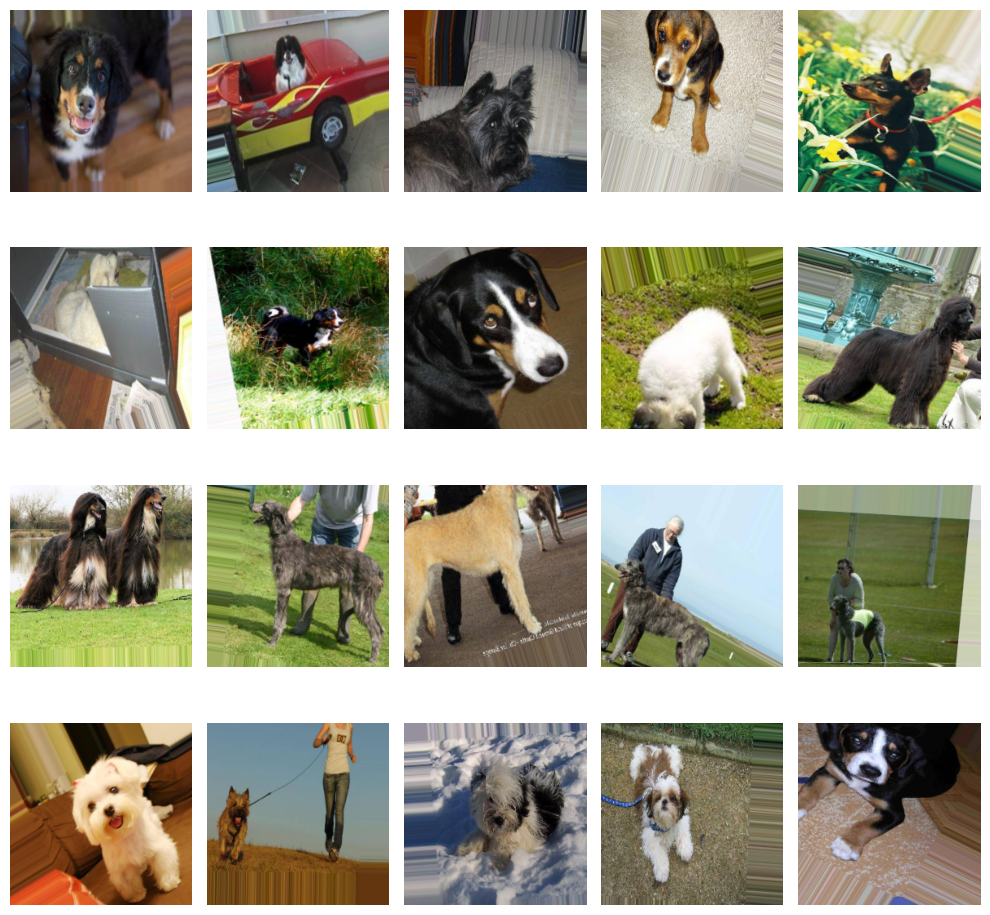

In [18]:
augmented_images = train_datagen.flow(X_train, y=y_train, shuffle=True)
plt.figure(figsize=(10, 10))
for i in range(20):
    augmented_image = next(augmented_images)[0][0]  # Use `next` function
    plt.subplot(4, 5, i + 1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [19]:
training_set=train_datagen.flow(X_train,y=y_train,batch_size=64)
testing_set=test_datagen.flow(X_test,y=y_test,batch_size=64)

# **Model Training**

In [20]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, Dropout, MaxPooling2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0  # Import EfficientNetB0
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [21]:
def get_features(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = model_preprocessor(input_layer)
    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs=input_layer, outputs=avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape:', feature_maps.shape)
    return feature_maps

# **Feature Extraction**

In [22]:
effnet_preprocessor = tf.keras.applications.efficientnet.preprocess_input
effnet_features = get_features(EfficientNetB4, effnet_preprocessor, (224, 224, 3), X)

# xception_preprocessor = tf.keras.applications.xception.preprocess_input
# xception_features = get_features(Xception, xception_preprocessor, (224, 224, 3), X) 

resnet_preprocessor = tf.keras.applications.resnet50.preprocess_input
resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step
Feature maps shape: (2184, 1792)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step
Feature maps shape: (2184, 2048)


In [23]:
final_features = np.concatenate([effnet_features, resnet_features], axis=-1)
# test_xception_features
print('Final feature maps shape:', final_features.shape)

Final feature maps shape: (2184, 3840)


In [24]:
model = Sequential()
model.add(Dropout(0.7, input_shape=(final_features.shape[1],)))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
checkpoint = ModelCheckpoint('best_model.h5.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [26]:
history = model.fit(final_features, y,
                    batch_size=128,
                    epochs=50,
                    validation_split=0.15,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/50
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1129 - loss: 3.5357  
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to best_model.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1694 - loss: 3.2136 - val_accuracy: 0.8750 - val_loss: 0.6390
Epoch 2/50
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7320 - loss: 0.9101 
Epoch 2: val_accuracy improved from 0.87500 to 0.92988, saving model to best_model.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7471 - loss: 0.8542 - val_accuracy: 0.9299 - val_loss: 0.2640
Epoch 3/50
11/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8730 - loss: 0.4226 
Epoch 3: val_accuracy improved from 0.92988 to 0.93902, saving model to best_model.h5.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8724 - loss: 0.4190 - val_accuracy: 0.9390 - val_loss: 0.1864
Epoch 4/50
10/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8950 - loss: 0.3300 
Epoch 4: val_accuracy improved from 0.9

In [27]:
# Extract features using EfficientNetB4
test_effnet_features = get_features(EfficientNetB4, effnet_preprocessor, (224, 224, 3), X_test)

# Extract features using ResNet50
test_resnet_features = get_features(ResNet50, resnet_preprocessor, (224, 224, 3), X_test)

# test_xception_features = get_features(Xception, xception_preprocessor, (224,224, 3) , X_test)

# Concatenate the features
test_final_features = np.concatenate([test_effnet_features, test_resnet_features], axis=-1)

print('Final test feature maps shape:', test_final_features.shape)


14/14 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step
Feature maps shape: (437, 1792)
14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step
Feature maps shape: (437, 2048)
Final test feature maps shape: (437, 3840)


In [28]:
# Predict on test data
# Ensure you load the best model
best_model = load_model('best_model.h5.keras')


test_predictions = best_model.predict(test_final_features)
test_predicted_labels = np.argmax(test_predictions, axis=1)
true_test_labels = np.argmax(y_test, axis=1)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Accuracy: 97.94%
                      precision    recall  f1-score   support

        afghan_hound       0.97      1.00      0.98        30
            airedale       1.00      1.00      1.00        19
  australian_terrier       1.00      1.00      1.00        23
             basenji       1.00      1.00      1.00        23
              beagle       0.96      1.00      0.98        23
bernese_mountain_dog       0.96      1.00      0.98        25
    blenheim_spaniel       1.00      0.95      0.98        22
               cairn       1.00      1.00      1.00        17
         entlebucher       1.00      0.94      0.97        17
      great_pyrenees       1.00      1.00      1.00        28
     irish_wolfhound       0.96      0.96      0.96        23
    japanese_spaniel       1.00      0.95      0.98        22
            leonberg       1.00      1.00      1.00        22
         maltese_dog       1.00      0.94      0.97        17
  miniature_pinscher       1.00      1.00      1.00 

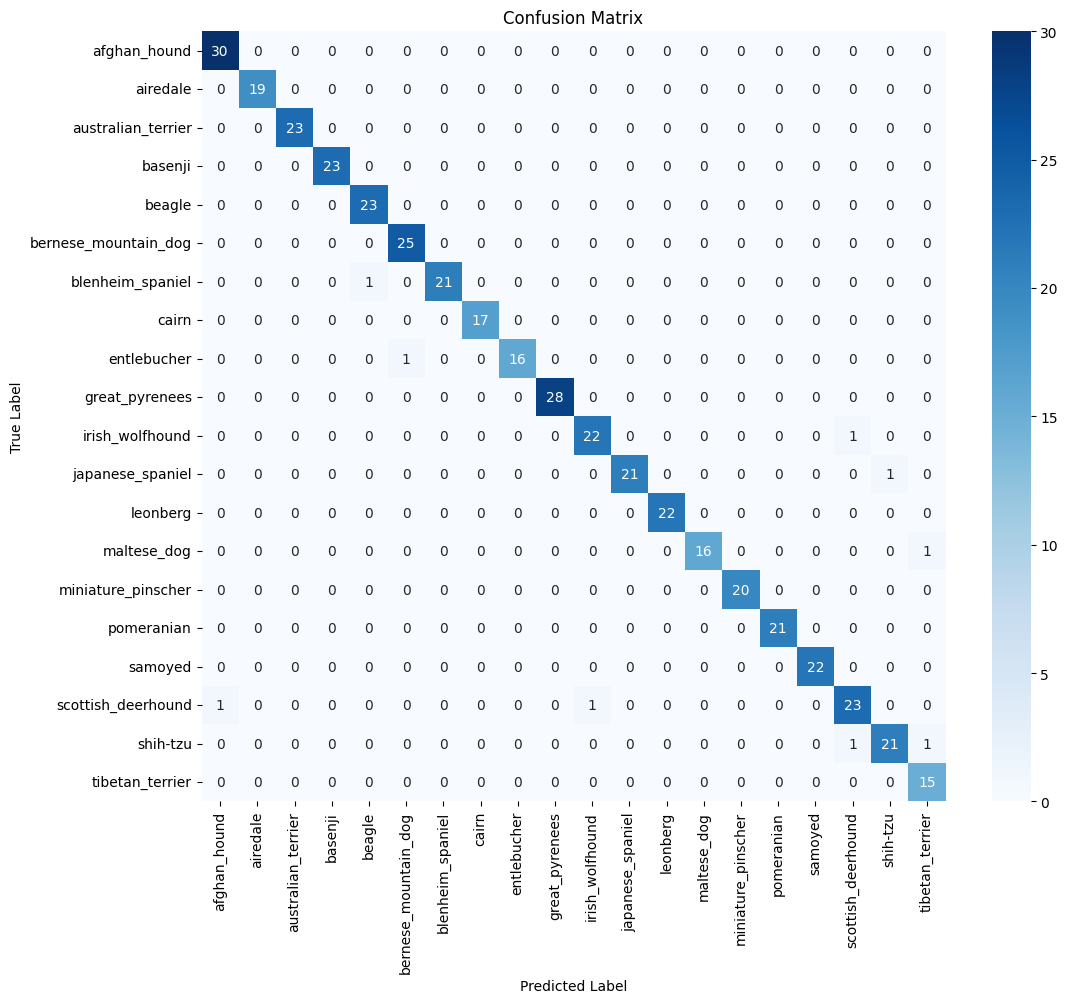

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(true_test_labels, test_predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Classification Report
class_report = classification_report(true_test_labels, test_predicted_labels, target_names=label_encoder.classes_)
print(class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_test_labels, test_predicted_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Prediction

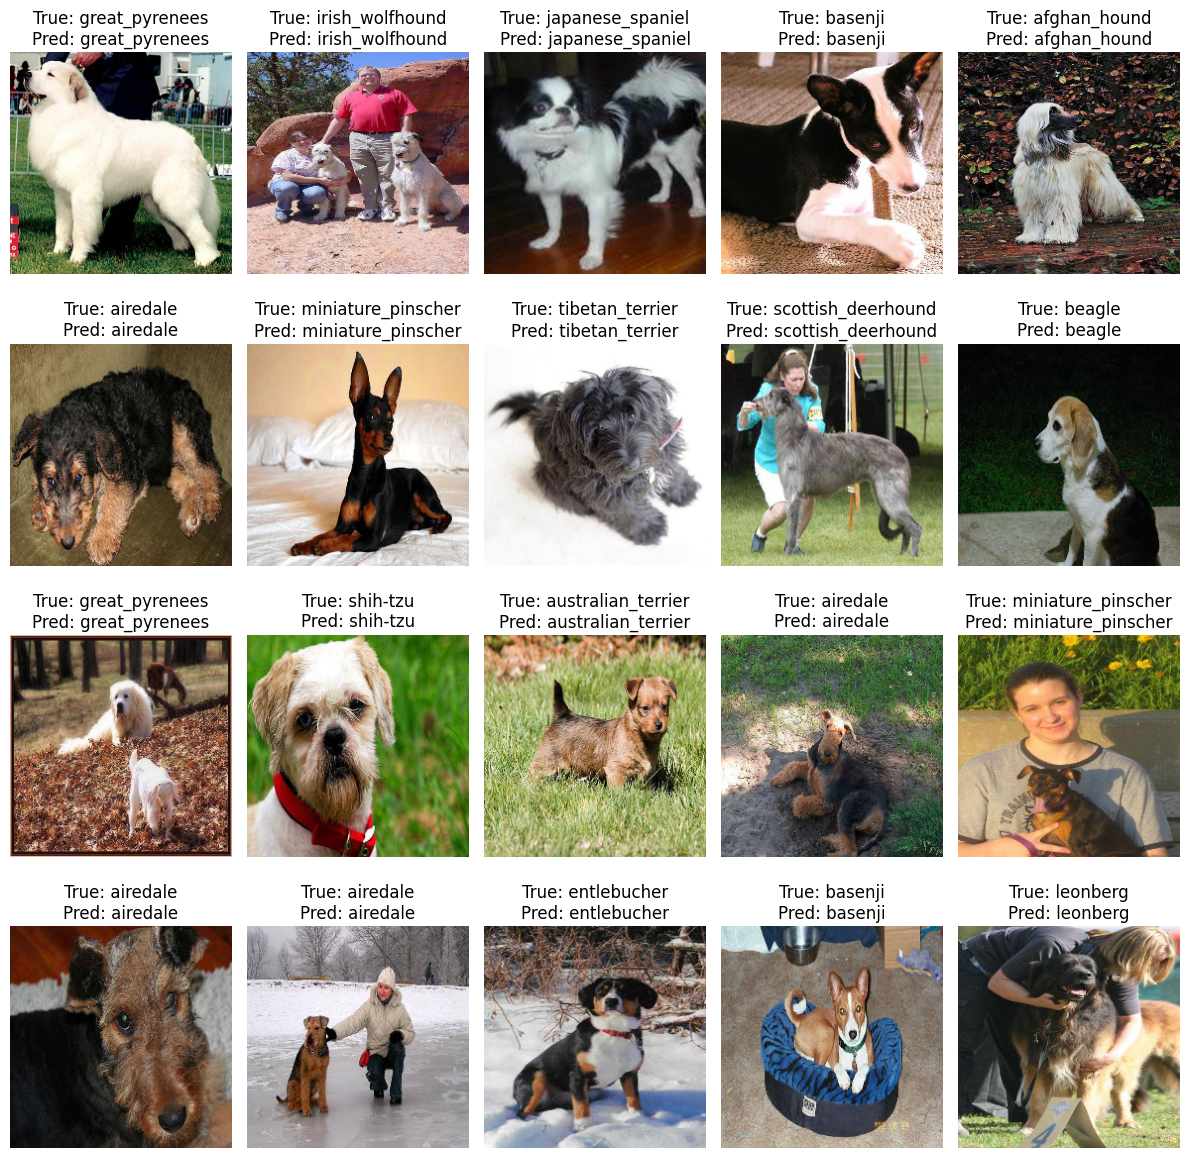

In [30]:
correctly_classified_indices = np.where(true_test_labels == test_predicted_labels)[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(correctly_classified_indices[:20]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f'True: {label_encoder.classes_[true_test_labels[idx]]}\nPred: {label_encoder.classes_[test_predicted_labels[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


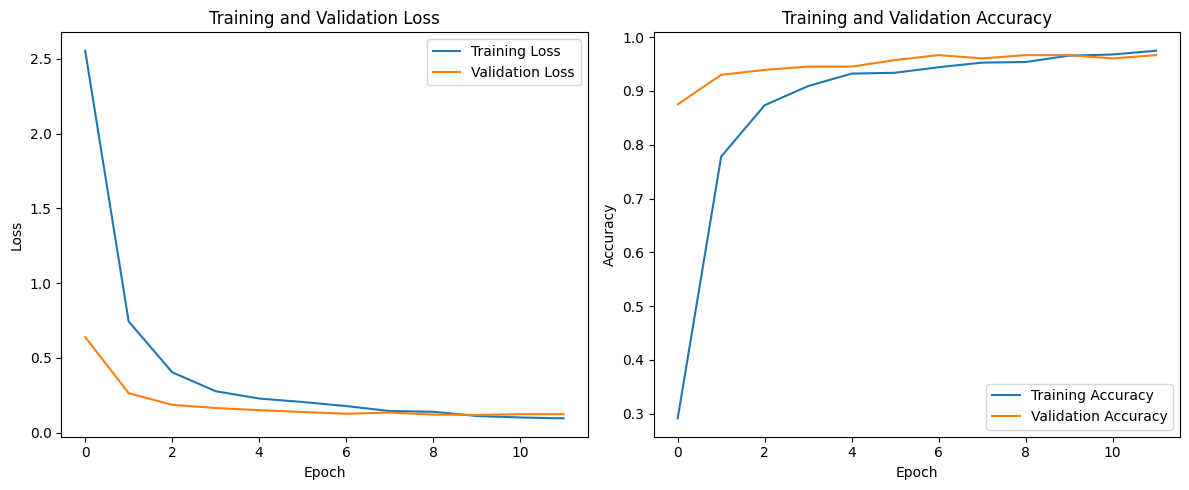

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

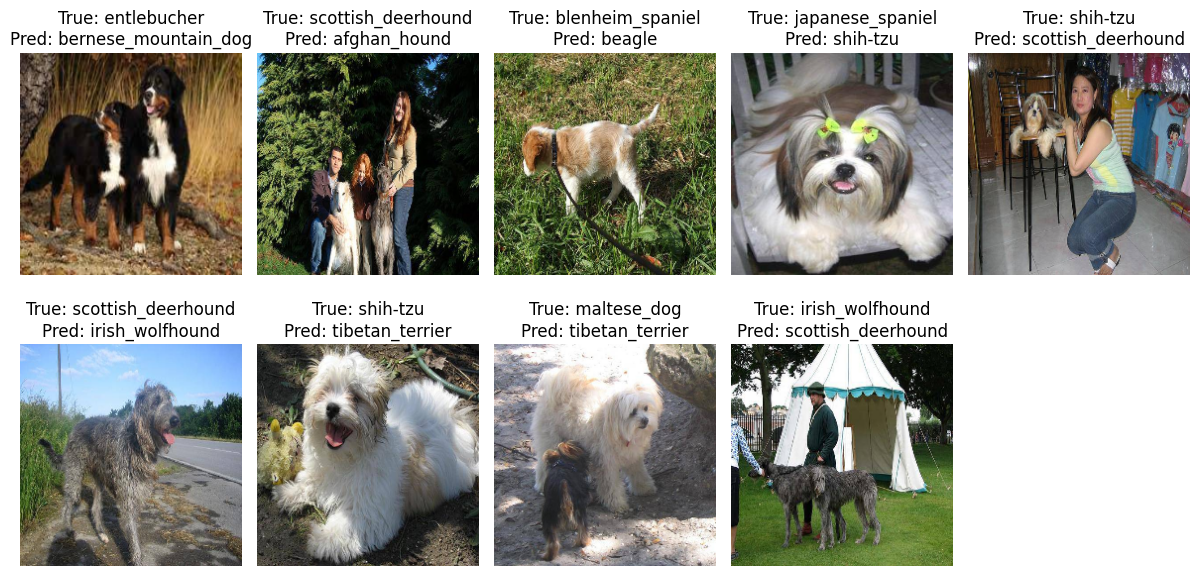

In [32]:
# Identify misclassified indices
misclassified_indices = np.where(true_test_labels != test_predicted_labels)[0]

# Plot misclassified examples
plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices[:20]):
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f'True: {label_encoder.classes_[true_test_labels[idx]]}\nPred: {label_encoder.classes_[test_predicted_labels[idx]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# **External Image For Testing that The Model is Working Expected Or Not!**

In [33]:

from keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, ResNet50
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from sklearn.preprocessing import LabelEncoder

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)  # Convert the image to numpy array
    img_tensor = np.expand_dims(img_tensor, axis=0)  # Add batch dimension
    return img_tensor

# Path to the specific image
specific_img_path = '/kaggle/input/external-dog-image-for-classifying/TibetanTerrier.jpg'

# Load and preprocess the image
img_tensor = load_and_preprocess_image(specific_img_path)

# Apply preprocessing functions
img_tensor_effnet = effnet_preprocess_input(img_tensor.copy())
img_tensor_resnet = resnet_preprocess_input(img_tensor.copy())

# Extract features using EfficientNetB4
test_effnet_features = get_features(EfficientNetB4, effnet_preprocess_input, (224, 224, 3), img_tensor_effnet)

# Extract features using ResNet50
test_resnet_features = get_features(ResNet50, resnet_preprocess_input, (224, 224, 3), img_tensor_resnet)

# Concatenate the features
test_final_features = np.concatenate([test_effnet_features, test_resnet_features], axis=-1)

print("EfficientNet features shape:", test_effnet_features.shape)
print("ResNet features shape:", test_resnet_features.shape)
print("Concatenated features shape:", test_final_features.shape)

# Load the best model
best_model = load_model('best_model.h5.keras')

# Make prediction
predictions = best_model.predict(test_final_features)
label_index = np.argmax(predictions[0])

# Create a dictionary to map class indices to class labels
class_labels = {index: label for index, label in enumerate(label_encoder.classes_)}
predicted_label = class_labels[label_index]

print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Feature maps shape: (1, 1792)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature maps shape: (1, 2048)
EfficientNet features shape: (1, 1792)
ResNet features shape: (1, 2048)
Concatenated features shape: (1, 3840)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted label: tibetan_terrier


**I hope this notebook will helpful! I want to learn that if my steps and practices are true or not. Please give me a comment! I'm pretty new at this.**